In [4]:
"""Train a Toxicity model using Keras."""
import keras
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import cPickle
import datetime
import json
import os
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv1D
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Embedding
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Input
from keras.layers import MaxPooling1D
from keras.models import load_model
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import gensim
%matplotlib inline
from keras import backend as K
import FairAI
# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [5]:
### parsing files from https://github.com/cbaziotis/ntua-slp-semeval2018/blob/master/dataloaders/task1.py
def parse_e_c(data_file):
    """

    Returns:
        X: a list of tweets
        y: a list of lists corresponding to the emotion labels of the tweets

    """
    with open(data_file, 'r') as fd:
        data = [l.strip().split('\t') for l in fd.readlines()][1:]
    X = [d[1] for d in data]
    # dict.values() does not guarantee the order of the elements
    # so we should avoid using a dict for the labels
    y = [[int(l) for l in d[2:]] for d in data]

    return X, y


def parse_oc(data_file, label_format='tuple'):
    """

    Returns:
        X: a list of tweets
        y: a list of (affect dimension, v) tuples corresponding to
         the ordinal classification targets of the tweets
    """
    with open(data_file, 'r') as fd:
        data = [l.strip().split('\t') for l in fd.readlines()][1:]
    X = [d[1] for d in data]
    y = [(d[2], int(d[3].split(':')[0])) for d in data]
    if label_format == 'list':
        y = [l[1] for l in y]
    return X, y


def parse_reg(data_file, label_format='tuple'):
    """
    The test datasets for the EI-reg and V-reg English tasks have two parts:
    1. The Tweet Test Set: tweets annotated for emotion/valence intensity;
    2. The Mystery Test Set: automatically generated sentences to test for
    unethical biases in NLP systems (with no emotion/valence annotations).

    Mystery Test Set: the last 16,937 lines with 'mystery' in the ID

    Returns:
        X: a list of tweets
        y: a list of (affect dimension, v) tuples corresponding to
         the regression targets of the tweets
    """
    with open(data_file, 'r') as fd:
        data = [l.strip().split('\t') for l in fd.readlines()][1:]
        data = [d for d in data if "mystery" not in d[0]]
    X = [d[1] for d in data]
    y = [(d[2], float(d[3])) for d in data]
    if label_format == 'list':
        y = [l[1] for l in y]
    return X, y

## We will be using the EEC corpus to tease out biases with respect to race and gender

In [6]:
df = pd.read_csv("../data/Equity-Evaluation-Corpus.csv")
a = pd.groupby(df,"Emotion")
a.aggregate('count')


/home/csweeney/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.groupby() is deprecated and will be removed; Please use the Series.groupby() or DataFrame.groupby() methods
  


,ID,Sentence,Template,Person,Gender,Race,Emotion word
Emotion,,,,,,,
anger,2100,2100,2100,2100,2100,1400,2100
fear,2100,2100,2100,2100,2100,1400,2100
joy,2100,2100,2100,2100,2100,1400,2100
sadness,2100,2100,2100,2100,2100,1400,2100


In [7]:
df

,ID,Sentence,Template,Person,Gender,Race,Emotion,Emotion word
0,2018-En-mystery-05498,Alonzo feels angry.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,angry
1,2018-En-mystery-11722,Alonzo feels furious.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,furious
2,2018-En-mystery-11364,Alonzo feels irritated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,irritated
3,2018-En-mystery-14320,Alonzo feels enraged.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,enraged
4,2018-En-mystery-14114,Alonzo feels annoyed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,anger,annoyed
5,2018-En-mystery-09419,Alonzo feels sad.,<person subject> feels <emotion word>.,Alonzo,male,African-American,sadness,sad
6,2018-En-mystery-16791,Alonzo feels depressed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,sadness,depressed
7,2018-En-mystery-10775,Alonzo feels devastated.,<person subject> feels <emotion word>.,Alonzo,male,African-American,sadness,devastated
8,2018-En-mystery-00419,Alonzo feels miserable.,<person subject> feels <emotion word>.,Alonzo,male,African-American,sadness,miserable
9,2018-En-mystery-11781,Alonzo feels dissapointed.,<person subject> feels <emotion word>.,Alonzo,male,African-American,sadness,dissapointed


## Model and util  helper function

In [8]:
def prep(embeddings,s0):
    X1=[]
    regex = re.compile('[^a-zA-Z] ')
    s1 = map(lambda x: regex.sub('', x.lower()[:-1]).split(" "),np.array(s0))
    s2 = map(lambda x: filter(lambda x: x in embeddings,x),s1)
    X =  map(lambda x: FairAI._np_normalize(embeddings[x]),s2)
    for index,i in enumerate(X):
            try:
                len(np.mean(X[index],axis=0))
                X1.append(np.mean(X[index],axis=0))
            except:
                print(X[index])
    return X1

In [9]:
def pearson_coeff(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = np.mean(x)
    my = np.mean(y)
    xm, ym = x-mx, y-my
    r_num = np.sum(np.multiply(xm,ym))
    r_den =np.sqrt(np.multiply(np.sum(np.square(xm)), np.sum(np.square(ym))))
    r = r_num / r_den
    return r
#     r = max(min(r, 1.0), -1.0)
#     return 1 - np.square(r)

In [11]:
#  code from https://github.com/conversationai/unintended-ml-bias-analysis for creating CNN model
DEFAULT_EMBEDDINGS_PATH = '../data/glove.6B.100d.txt'
#DEFAULT_EMBEDDINGS_PATH = './glove_debias_new_sentiment_with_toxic_vec.txt'

DEFAULT_MODEL_DIR = '../models'

DEFAULT_HPARAMS = {
    'max_sequence_length': 25,
    'max_num_words': 2000000,
    'embedding_dim': 100,
    'embedding_trainable': False,
    'learning_rate': 0.00001,
    'stop_early': False,
    'es_patience': 1,  # Only relevant if STOP_EARLY = True
    'es_min_delta': 0,  # Only relevant if STOP_EARLY = True
    'batch_size': 128,
    'epochs': 200,
    'dropout_rate': 0.1,
    'cnn_filter_sizes': [128, 128, 128],
    'cnn_kernel_sizes': [5, 5, 5],
    'cnn_pooling_sizes': [5, 5, 40],
    'verbose': False
}


def compute_auc(y_true, y_pred):
  try:
    return metrics.roc_auc_score(y_true, y_pred)
  except ValueError:
    return np.nan


### Model scoring

# Scoring these dataset for dozens of models actually takes non-trivial amounts
# of time, so we save the results as a CSV. The resulting CSV includes all the
# columns of the original dataset, and in addition has columns for each model,
# containing the model's scores.
def score_dataset(df, models, text_col):
    """Scores the dataset with each model and adds the scores as new columns."""
    for model in models:
        name = model.get_model_name()
        print('{} Scoring with {}...'.format(datetime.datetime.now(), name))
        df[name] = model.predict(df[text_col])

def load_maybe_score(models, orig_path, scored_path, postprocess_fn):
    if os.path.exists(scored_path):
        print('Using previously scored data:', scored_path)
        return pd.read_csv(scored_path)

    dataset = pd.read_csv(orig_path)
    postprocess_fn(dataset)
    score_dataset(dataset, models, 'text')
    print('Saving scores to:', scored_path)
    dataset.to_csv(scored_path)
    return dataset

def postprocess_madlibs(madlibs):
    """Modifies madlibs data to have standard 'text' and 'label' columns."""
    # Native madlibs data uses 'Label' column with values 'BAD' and 'NOT_BAD'.
    # Replace with a bool.
    madlibs['label'] = madlibs['Label'] == 'BAD'
    madlibs.drop('Label', axis=1, inplace=True)
    madlibs.rename(columns={'Text': 'text'}, inplace=True)

def postprocess_wiki_dataset(wiki_data):
    """Modifies Wikipedia dataset to have 'text' and 'label' columns."""
    wiki_data.rename(columns={'is_toxic': 'label',
                              'comment': 'text'},
                     inplace=True)


class ToxModel():
  """Toxicity model."""

  def __init__(self,
               model_name=None,
               model_dir=DEFAULT_MODEL_DIR,
               embeddings_path=DEFAULT_EMBEDDINGS_PATH,
               hparams=None):
    self.model_dir = model_dir
    self.embeddings_path = embeddings_path
    self.model_name = model_name
    self.model = None
    self.tokenizer = None
    self.hparams = DEFAULT_HPARAMS.copy()
    if hparams:
      self.update_hparams(hparams)
    if model_name:
      self.load_model_from_name(model_name)
    self.print_hparams()

  def print_hparams(self):
    print('Hyperparameters')
    print('---------------')
    for k, v in self.hparams.iteritems():
      print('{}: {}'.format(k, v))
    print('')

  def update_hparams(self, new_hparams):
    self.hparams.update(new_hparams)

  def get_model_name(self):
    return self.model_name

  def save_hparams(self, model_name):
    self.hparams['model_name'] = model_name
    with open(
        os.path.join(self.model_dir, '%s_hparams.json' % self.model_name),
        'w') as f:
      json.dump(self.hparams, f, sort_keys=True)

  def load_model_from_name(self, model_name):
    self.model = load_model(
        os.path.join(self.model_dir, '%s_model.h5' % model_name))
    self.tokenizer = cPickle.load(
        open(
            os.path.join(self.model_dir, '%s_tokenizer.pkl' % model_name),
            'rb'))
    with open(
        os.path.join(self.model_dir, '%s_hparams.json' % self.model_name),
        'r') as f:
      self.hparams = json.load(f)

  def fit_and_save_tokenizer(self, texts):
    """Fits tokenizer on texts and pickles the tokenizer state."""
    self.tokenizer = Tokenizer(num_words=self.hparams['max_num_words'])
    gender = ["she","he","her","him", "woman"," man"," girl"," boy"," sister"," brother"," daughter"," son"," wife"," husband"," girlfriend","boyfriend"," mother"," father", "aunt"," uncle","mommy","dad"]
    names = ["Ebony","Alonzo","Amanda","Adam","Jasmine","Alphonse","Betsy","Alan","Lakisha","Darnell","Courtney","Andrew","Latisha","Jamel","Ellen","Frank","Latoya","Jerome","Heather","Harry","Nichelle","Lamar","Katie","Jack","Shaniqua","Leroy","Kristin","Josh","Shereen","Malik","Melanie","Justin","Tanisha","Terrence","Nancy","Roger","Tia","Torrance","Stephanie","Ryan"]
    self.tokenizer.fit_on_texts(texts+gender+names)
    cPickle.dump(self.tokenizer,
                 open(
                     os.path.join(self.model_dir,
                                  '%s_tokenizer.pkl' % self.model_name), 'wb'))

  def prep_text(self, texts):
    """Turns text into into padded sequences.

    The tokenizer must be initialized before calling this method.

    Args:
      texts: Sequence of text strings.

    Returns:
      A tokenized and padded text sequence as a model input.
    """
    text_sequences = self.tokenizer.texts_to_sequences(texts)
    return pad_sequences(
        text_sequences, maxlen=self.hparams['max_sequence_length'])

  def load_embeddings(self):
    """Loads word embeddings."""
    embeddings_index = {}
    with open(self.embeddings_path) as f:
      for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    self.embedding_matrix = np.zeros((len(self.tokenizer.word_index) + 1,
                                      self.hparams['embedding_dim']))
    num_words_in_embedding = 0
    for word, i in self.tokenizer.word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
        num_words_in_embedding += 1
        # words not found in embedding index will be all-zeros.
        self.embedding_matrix[i] = embedding_vector

  def train(self, train_data,train_labels,valid_data,valid_labels, model_name):
    """Trains the model."""
    self.model_name = model_name
    self.save_hparams(model_name)

    print('Fitting tokenizer...')
    self.fit_and_save_tokenizer(train_data)
    print('Tokenizer fitted!')

    print('Preparing data...')
    train_text, train_labels = (self.prep_text(train_data),train_labels)
    valid_text, valid_labels = (self.prep_text(valid_data),valid_labels)
    print('Data prepared!')

    print('Loading embeddings...')
    self.load_embeddings()
    print('Embeddings loaded!')

    print('Building model graph...')
    self.build_model_1()
    print('Training model...')

    save_path = os.path.join(self.model_dir, '%s_model.h5' % self.model_name)
    callbacks = [
        ModelCheckpoint(
            save_path, save_best_only=True, verbose=self.hparams['verbose'])
    ]
    if self.hparams['stop_early']:
      callbacks.append(
          EarlyStopping(
              min_delta=self.hparams['es_min_delta'],
              monitor='val_loss',
              patience=self.hparams['es_patience'],
              verbose=self.hparams['verbose'],
              mode='auto'))
    print(train_text[0],train_labels[0])
    print(np.shape(train_text),np.shape(train_labels))
    self.model.fit(
        train_text,
        train_labels,
        batch_size=self.hparams['batch_size'],
        epochs=self.hparams['epochs'],
        validation_data=(valid_text, valid_labels),
        callbacks=callbacks,
        verbose=0)
    print('Model trained!')
    print('Best model saved to {}'.format(save_path))
    print('Loading best model from checkpoint...')
    self.model = load_model(save_path)
    print('Model loaded!')

  def build_model(self):
    """Builds model graph."""
    sequence_input = Input(
        shape=(self.hparams['max_sequence_length'],), dtype='int32')
    embedding_layer = Embedding(
        len(self.tokenizer.word_index) + 1,
        self.hparams['embedding_dim'],
        weights=[self.embedding_matrix],
        input_length=self.hparams['max_sequence_length'],
        trainable=self.hparams['embedding_trainable'])

    embedded_sequences = embedding_layer(sequence_input)
    x = embedded_sequences
    for filter_size, kernel_size, pool_size in zip(
        self.hparams['cnn_filter_sizes'], self.hparams['cnn_kernel_sizes'],
        self.hparams['cnn_pooling_sizes']):
      x = self.build_conv_layer(x, filter_size, kernel_size, pool_size)

    x = Flatten()(x)
    x = Dropout(self.hparams['dropout_rate'])(x)
    # TODO(nthain): Parametrize the number and size of fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)

    preds = Dense(1)(x)

    rmsprop = RMSprop(lr=self.hparams['learning_rate'])
    self.model = Model(sequence_input, preds)
    self.model.compile(
        loss='mse', optimizer=rmsprop)

  def build_conv_layer(self, input_tensor, filter_size, kernel_size, pool_size):
    output = Conv1D(
        filter_size, kernel_size, activation='relu', padding='same')(
            input_tensor)
    if pool_size:
      output = MaxPooling1D(pool_size, padding='same')(output)
    else:
      # TODO(nthain): This seems broken. Fix.
      output = GlobalMaxPooling1D()(output)
    return output
  
  def build_model_1(self):
    """Builds model graph."""
    sequence_input = Input(
        shape=(self.hparams['max_sequence_length'],), dtype='int32')
    embedding_layer = Embedding(
        len(self.tokenizer.word_index) + 1,
        self.hparams['embedding_dim'],
        weights=[self.embedding_matrix],
        input_length=self.hparams['max_sequence_length'],
        trainable=self.hparams['embedding_trainable'])

    embedded_sequences = embedding_layer(sequence_input)
    x = embedded_sequences
    x= keras.layers.Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2))(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    preds = Dense(1,kernel_initializer='normal')(x)

    rmsprop = RMSprop(lr=self.hparams['learning_rate'])
    self.model = Model(sequence_input, preds)
    self.model.compile(
        loss='mse', optimizer=rmsprop, metrics=['accuracy'])
  def predict(self, texts):
    """Returns model predictions on texts."""
    data = self.prep_text(texts)
    return self.model.predict(data)[:, 1]

  def score_auc(self, texts, labels):
    preds = self.predict(texts)
    return compute_auc(labels, preds)

  def summary(self):
    return self.model.summary()


## Define dataframes to hold data

In [12]:
lim = 500
df_aa=pd.DataFrame(index=[np.zeros(lim),np.zeros(lim),np.zeros(lim),np.zeros(lim)],columns=["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"])
df_w=pd.DataFrame(index=[np.zeros(lim),np.zeros(lim),np.zeros(lim),np.zeros(lim)],columns=["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"])
df_f=pd.DataFrame(index=[np.zeros(lim),np.zeros(lim),np.zeros(lim),np.zeros(lim)],columns=["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"])
df_m=pd.DataFrame(index=[np.zeros(lim),np.zeros(lim),np.zeros(lim),np.zeros(lim)],columns=["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"])

## Train LSTM or CNN Models with Original Word Embeddings

In [218]:
X_reg,y_reg= parse_reg("../data/SemEval2018-Task1-AIT-Test-gold/V-reg/2018-Valence-reg-En-test-gold.txt")
X,y = parse_reg("../data/2018-Valence-reg-En-train.txt")
from keras.layers import LSTM
model = ToxModel()
model.train(X,np.array(zip(*y)[1]),X_reg,np.array(zip(*y_reg)[1]), 'test')
data = model.prep_text(X_reg)
print("pearson score ",pearson_coeff(model.model.predict(data)[:,0],np.array(zip(*y_reg)[1])))
a= pd.read_csv("../data/Equity-Evaluation-Corpus.csv").dropna(subset=["Emotion"])
aa=model.prep_text(a[a.Race=='African-American']["Sentence"])
w=model.prep_text(a[a.Race=='European']["Sentence"])
aa= model.model.predict(aa)[:,0]
w= model.model.predict(w)[:,0]
n=np.where((aa-w)>0)
print(np.mean(aa[n]-w[n]),"aa higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_aa["LSTM GloVe"] = (aa[n]-w[n])[:lim]
n=np.where((w-aa)>0)
print(np.mean(aa[n]-w[n]), "w higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_w["LSTM GloVe"] = (aa[n]-w[n])[:lim]
f=model.prep_text(a[a.Gender=='female']["Sentence"])
m=model.prep_text(a[a.Gender=='male']["Sentence"])
f= model.model.predict(f)[:,0]
m= model.model.predict(m)[:,0]
n=np.where((f-m)>0)
print(np.mean(f[n]-m[n]),"female higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))
df_f["LSTM GloVe"] = (f[n]-m[n])[:lim]
n=np.where((m-f)>0)
df_m["LSTM GloVe"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]), "male higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))

Hyperparameters
---------------
max_num_words: 2000000
dropout_rate: 0.1
verbose: False
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 1e-05
es_patience: 1
batch_size: 128
embedding_dim: 100
epochs: 200
cnn_filter_sizes: [128, 128, 128]
cnn_kernel_sizes: [5, 5, 5]
max_sequence_length: 25
stop_early: False
embedding_trainable: False

Fitting tokenizer...
Tokenizer fitted!
Preparing data...
Data prepared!
Loading embeddings...
Embeddings loaded!
Building model graph...
Training model...
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1682  566  415  136] 0.6
(1181, 25) (1181,)
Model trained!
Best model saved to ../models/test_model.h5
Loading best model from checkpoint...
Model loaded!
pearson score  0.5321759728722477
0.017419929 aa higher 2.5331974e-06 0.064638525
-0.021127518 w higher 0.000100165606 0.10407704
0.012809797 female higher 3.8444996e-06 0.057582974
-0.014643236 male higher 9.059906e-06 0.0619345


## Traind LSTM or CNN Models with Our Debiased Word Embeddings

In [243]:
X_reg,y_reg= parse_reg("../data/SemEval2018-Task1-AIT-Test-gold/V-reg/2018-Valence-reg-En-test-gold.txt")
X,y = parse_reg("../data/2018-Valence-reg-En-train.txt")
from keras.layers import LSTM
model = ToxModel(embeddings_path='./glove_debias_new_sentiment_with_toxic_vec.txt')
model.train(X,np.array(zip(*y)[1]),X_reg,np.array(zip(*y_reg)[1]), 'test')
data = model.prep_text(X_reg)
print("pearson score ",pearson_coeff(model.model.predict(data)[:,0],np.array(zip(*y_reg)[1])))
a= pd.read_csv("../data/Equity-Evaluation-Corpus.csv").dropna(subset=["Emotion"])
aa=model.prep_text(a[a.Race=='African-American']["Sentence"])
w=model.prep_text(a[a.Race=='European']["Sentence"])
aa= model.model.predict(aa)[:,0]
w= model.model.predict(w)[:,0]
n=np.where((aa-w)>0)
print(np.mean(aa[n]-w[n]),"aa higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_aa["LSTM GloVe Debiased"] = (aa[n]-w[n])[:lim]
n=np.where((w-aa)>0)
print(np.mean(aa[n]-w[n]), "w higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_w["LSTM GloVe Debiased"] = (aa[n]-w[n])[:lim]
f=model.prep_text(a[a.Gender=='female']["Sentence"])
m=model.prep_text(a[a.Gender=='male']["Sentence"])
f= model.model.predict(f)[:,0]
m= model.model.predict(m)[:,0]
n=np.where((f-m)>0)
print(np.mean(f[n]-m[n]),"female higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))
df_f["LSTM GloVe Debiased"] = (f[n]-m[n])[:lim]
n=np.where((m-f)>0)
df_m["LSTM GloVe Debiased"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]), "male higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))

Hyperparameters
---------------
max_num_words: 2000000
dropout_rate: 0.1
verbose: False
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 1e-05
es_patience: 1
batch_size: 128
embedding_dim: 100
epochs: 200
cnn_filter_sizes: [128, 128, 128]
cnn_kernel_sizes: [5, 5, 5]
max_sequence_length: 25
stop_early: False
embedding_trainable: False

Fitting tokenizer...
Tokenizer fitted!
Preparing data...
Data prepared!
Loading embeddings...
Embeddings loaded!
Building model graph...
Training model...
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1682  566  415  136] 0.6
(1181, 25) (1181,)
Model trained!
Best model saved to ../models/test_model.h5
Loading best model from checkpoint...
Model loaded!
pearson score  0.5328641958824717
0.004129061 aa higher 2.115965e-06 0.018898726
-0.003947313 w higher 1.013279e-06 0.017623305
0.009152567 female higher 3.6656857e-06 0.048291057
-0.0020842575 male higher 1.4781952e-05 0.007938832


## Train simple svr on original word embeddings

In [220]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = '../data/glove.6B/glove.6B.100d.txt'
word2vec_output_file = '../data/glove.6B/glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings = gensim.models.KeyedVectors.load_word2vec_format(word2vec_output_file,binary=False)

In [221]:
import re
X_reg,y_reg= parse_reg("../data/SemEval2018-Task1-AIT-Test-gold/V-reg/2018-Valence-reg-En-test-gold.txt")
X,y = parse_reg("../data/2018-Valence-reg-En-train.txt")
X1=[]
y1=[]
X= map(lambda x: map(lambda x: FairAI._np_normalize(embeddings[x]),filter(lambda x: x in embeddings,re.sub(r'\W +', '', x).split(" "))),X)
for index,i in enumerate(X):
    if isinstance(X[index], list):
        try:
            len(np.mean(X[index],axis=0))
            X1.append(np.mean(X[index],axis=0))
            y1.append(y[index])
        except:
            pass
#             print(X[index])
X_reg1 = []    
y_reg1=[]
X_reg= map(lambda x: map(lambda x: FairAI._np_normalize(embeddings[x]),filter(lambda x: x in embeddings,re.sub(r'\W +', '', x).split(" "))),X_reg)
for index,i in enumerate(X_reg):
    if isinstance(X_reg[index], list):
        try:
            len(np.mean(X_reg[index],axis=0))
            X_reg1.append(np.mean(X_reg[index],axis=0))
            y_reg1.append(y_reg[index])
        except:
            pass
#             print(X_reg[index])
from sklearn.svm import SVR
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf.fit(np.stack(X1), np.array(zip(*y1)[1])) 
a=[]
for index,i in enumerate(X_reg1):
    try:
        a.append(clf.predict([i])[0])
    except:
        a.append(0.5)
import scipy
pearson_coeff(np.array(a),np.array(zip(*y_reg1)[1]))
print("pearson",scipy.stats.pearsonr(np.array(a),np.array(zip(*y_reg1)[1]))[0])
a= pd.read_csv("../data/Equity-Evaluation-Corpus.csv").dropna(subset=["Emotion"])
aa=prep(embeddings,a[a.Race=='African-American']["Sentence"])
w=prep(embeddings,a[a.Race=='European']["Sentence"])
aa= clf.predict(aa)
w= clf.predict(w)
n=np.where((aa-w)>0)
print(np.mean(aa[n]-w[n]),"aa higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_aa["SVR GloVe"] = (aa[n]-w[n])[:lim]
n=np.where((w-aa)>0)
df_w["SVR GloVe"] = (aa[n]-w[n])[:lim]
print(np.mean(aa[n]-w[n]), "w higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
f=prep(embeddings,a[a.Gender=='female']["Sentence"])
m=prep(embeddings,a[a.Gender=='male']["Sentence"])
f= clf.predict(f)
m= clf.predict(m)
n=np.where((f-m)>0)
df_f["SVR GloVe"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]),"female higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))
n=np.where((m-f)>0)
df_m["SVR GloVe"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]), "male higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))

pearson 0.42679357682664903
0.008183955293493852 aa higher 0.0016146227239554056 0.034396843695754464
-0.010905066373856678 w higher 0.0013547058658714972 0.046126028305329414
0.005819814610315369 female higher 9.486929435809088e-06 0.041463343958538124
-0.007492478820825512 male higher 2.615195264565884e-06 0.04613434107306824


## train svr model on our debiased word embedding model

In [222]:
glove_input_file = './glove_debias_new_sentiment_with_toxic_vec.txt'
embeddings = gensim.models.KeyedVectors.load_word2vec_format(glove_input_file,binary=False)

In [223]:
import re
X_reg,y_reg= parse_reg("../data/SemEval2018-Task1-AIT-Test-gold/V-reg/2018-Valence-reg-En-test-gold.txt")
X,y = parse_reg("../data/2018-Valence-reg-En-train.txt")
X1=[]
y1=[]
X= map(lambda x: map(lambda x: FairAI._np_normalize(embeddings[x]),filter(lambda x: x in embeddings,re.sub(r'\W +', '', x).split(" "))),X)
for index,i in enumerate(X):
    if isinstance(X[index], list):
        try:
            len(np.mean(X[index],axis=0))
            X1.append(np.mean(X[index],axis=0))
            y1.append(y[index])
        except:
            pass
#             print(X[index])
X_reg1 = []    
y_reg1=[]
X_reg= map(lambda x: map(lambda x: FairAI._np_normalize(embeddings[x]),filter(lambda x: x in embeddings,re.sub(r'\W +', '', x).split(" "))),X_reg)
for index,i in enumerate(X_reg):
    if isinstance(X_reg[index], list):
        try:
            len(np.mean(X_reg[index],axis=0))
            X_reg1.append(np.mean(X_reg[index],axis=0))
            y_reg1.append(y_reg[index])
        except:
            pass
#             print(X_reg[index])
from sklearn.svm import SVR
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)
clf.fit(np.stack(X1), np.array(zip(*y1)[1])) 
a=[]
for index,i in enumerate(X_reg1):
    try:
        a.append(clf.predict([i])[0])
    except:
        a.append(0.5)
import scipy
pearson_coeff(np.array(a),np.array(zip(*y_reg1)[1]))
print("pearson",scipy.stats.pearsonr(np.array(a),np.array(zip(*y_reg1)[1]))[0])
a= pd.read_csv("../data/Equity-Evaluation-Corpus.csv").dropna(subset=["Emotion"])
aa=prep(embeddings,a[a.Race=='African-American']["Sentence"])
w=prep(embeddings,a[a.Race=='European']["Sentence"])
aa= clf.predict(aa)
w= clf.predict(w)
n=np.where((aa-w)>0)
print(np.mean(aa[n]-w[n]),"aa higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
df_aa["SVR GloVe Debiased"] = (aa[n]-w[n])[:lim]
n=np.where((w-aa)>0)
df_w["SVR GloVe Debiased"] = (aa[n]-w[n])[:lim]
print(np.mean(aa[n]-w[n]), "w higher",np.min(np.abs(aa[n]-w[n])),np.max(np.abs(aa[n]-w[n])))
f=prep(embeddings,a[a.Gender=='female']["Sentence"])
m=prep(embeddings,a[a.Gender=='male']["Sentence"])
f= clf.predict(f)
m= clf.predict(m)
n=np.where((f-m)>0)
df_f["SVR GloVe Debiased"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]),"female higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))
n=np.where((m-f)>0)
df_m["SVR GloVe Debiased"] = (f[n]-m[n])[:lim]
print(np.mean(f[n]-m[n]), "male higher",np.min(np.abs(f[n]-m[n])),np.max(np.abs(f[n]-m[n])))

pearson 0.4247024530910067
0.0014931708468486399 aa higher 4.018651077453139e-05 0.009866825385326239
-0.001509635326499623 w higher 0.00012587774425409926 0.008593105113279598
0.003217850984449998 female higher 0.00014071059176157252 0.018326348658936453
-0.0014322613263060286 male higher 9.391295215577244e-05 0.008733441048388357


# Plot results for various bias groups

LSTM GloVe  mean  0.015952539 range 2.5331974e-06 0.06429204
LSTM GloVe Debiased  mean  0.0041838633 range 2.115965e-06 0.018898726
SVR GloVe  mean  0.008465730922424253 range 0.0016146227239554056 0.034396843695754464
SVR GloVe Debiased  mean  0.0021176076014369975 range 5.530269216258432e-05 0.009866825385326239


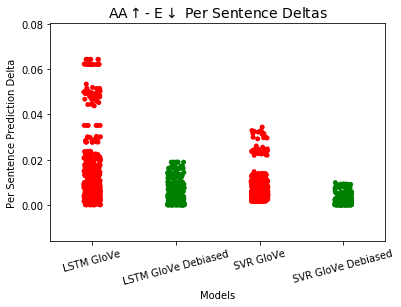

In [275]:
plot = seaborn.stripplot(data=df_aa,palette={"LSTM GloVe":'red',"LSTM GloVe Debiased":'green',"SVR GloVe":'r',"SVR GloVe Debiased":'g'}) 
plot.get_figure().savefig('/home/csweeney/Downloads/df_aa', format='png',dpi=300,bbox_inches='tight')
plot.set_xticklabels(labels=["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"],rotation=15)
plot.set(xlabel='Models', ylabel='Per Sentence Prediction Delta')
plot.set_title("AA$\uparrow$- E$\downarrow$ Per Sentence Deltas",{'fontsize':14})
for i in ["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"]:
    print(i, " mean ", np.mean(df_aa[i]),"range", np.min(np.abs(df_aa[i])),np.max(np.abs(df_aa[i])))
plot.get_figure().savefig('/home/csweeney/Downloads/df_aa.png', format='png',dpi=300,bbox_inches='tight')

LSTM GloVe  mean  -0.033548407 range 0.0018308461 0.10407704
LSTM GloVe Debiased  mean  -0.004608564 range 1.21593475e-05 0.016888887
SVR GloVe  mean  -0.020297313764908075 range 0.002928414654543854 0.046126028305329414
SVR GloVe Debiased  mean  -0.002403699656482522 range 0.00026387927741544637 0.008593105113279598


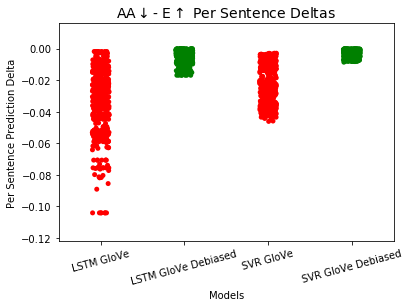

In [276]:
plot = seaborn.stripplot(data=df_w,palette={"LSTM GloVe":'red',"LSTM GloVe Debiased":'green',"SVR GloVe":'r',"SVR GloVe Debiased":'g'}) 
plot.get_figure().savefig('/home/csweeney/Downloads/df_w', format='png',dpi=300,bbox_inches='tight')
plot.set_xticklabels(labels=["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"],rotation=15)
plot.set(xlabel='Models', ylabel='Per Sentence Prediction Delta')
plot.set_title("AA$\downarrow$- E$\uparrow$ Per Sentence Deltas",{'fontsize':14})
for i in ["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"]:
    print(i, " mean ", np.mean(df_w[i]),"range", np.min(np.abs(df_w[i])),np.max(np.abs(df_w[i])))
plot.get_figure().savefig('/home/csweeney/Downloads/df_w.png', format='png',dpi=300,bbox_inches='tight')

LSTM GloVe  mean  0.016618289 range 3.8444996e-06 0.057324737
LSTM GloVe Debiased  mean  0.012048254 range 2.2143126e-05 0.0399144
SVR GloVe  mean  0.009818018692000113 range 0.00016437733529228726 0.041463343958538124
SVR GloVe Debiased  mean  0.005355079145958812 range 0.00031750681633457845 0.018326348658936453


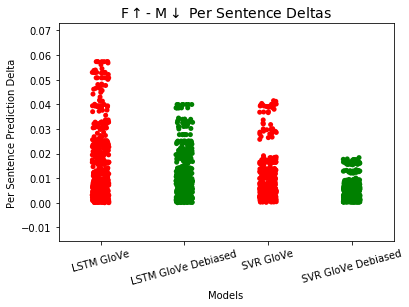

In [277]:
plot = seaborn.stripplot(data=df_f,palette={"LSTM GloVe":'red',"LSTM GloVe Debiased":'green',"SVR GloVe":'r',"SVR GloVe Debiased":'g'}) 
plot.get_figure().savefig('/home/csweeney/Downloads/df_f', format='png',dpi=300,bbox_inches='tight')
plot.set_xticklabels(labels=["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"],rotation=15)
plot.set(xlabel='Models', ylabel='Per Sentence Prediction Delta')
plot.set_title("F$\uparrow$- M$\downarrow$ Per Sentence Deltas",{'fontsize':14})
for i in ["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"]:
    print(i, " mean ", np.mean(df_f[i]),"range", np.min(np.abs(df_f[i])),np.max(np.abs(df_f[i])))
plot.get_figure().savefig('/home/csweeney/Downloads/df_f.png', format='png',dpi=300,bbox_inches='tight')

LSTM GloVe  mean  -0.0220159 range 1.1354685e-05 0.0619345
LSTM GloVe Debiased  mean  -0.0024302602 range 6.93202e-05 0.007938832
SVR GloVe  mean  -0.013868873568887304 range 0.00018959260314233006 0.04613434107306824
SVR GloVe Debiased  mean  -0.001909558369117846 range 0.00018914390710356166 0.008733441048388357


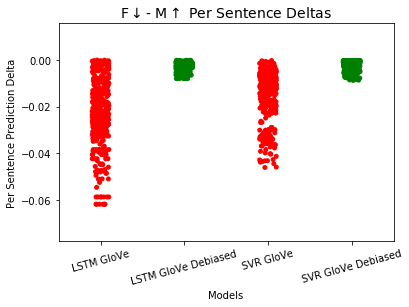

In [278]:
plot = seaborn.stripplot(data=df_m,palette={"LSTM GloVe":'red',"LSTM GloVe Debiased":'green',"SVR GloVe":'r',"SVR GloVe Debiased":'g'}) 
plot.get_figure().savefig('/home/csweeney/Downloads/df_m', format='png',dpi=300,bbox_inches='tight')
plot.set_xticklabels(labels=["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"],rotation=15)
plot.set(xlabel='Models', ylabel='Per Sentence Prediction Delta')
plot.set_title("F$\downarrow$- M$\uparrow$ Per Sentence Deltas",{'fontsize':14})

for i in ["LSTM GloVe","LSTM GloVe Debiased","SVR GloVe","SVR GloVe Debiased"]:
    print(i, " mean ", np.mean(df_m[i]),"range", np.min(np.abs(df_m[i])),np.max(np.abs(df_m[i])))
plot.get_figure().savefig('/home/csweeney/Downloads/df_m.png', format='png',dpi=300,bbox_inches='tight')